In [1]:
# Loading libraries
%matplotlib inline
import os
import os.path
from netCDF4 import Dataset
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc 
import fnmatch
from cycler import cycler
import pandas as pd
from pandas import read_csv, to_datetime, DataFrame
import datetime
import time
import matplotlib.dates as mdates

from matplotlib.path import Path
from matplotlib.patches import PathPatch
from mpl_toolkits.basemap import Basemap # Basemap pour les cartes

In [4]:
test = pd.read_table('../DATA/LONG_SIMS/BestAjustRivE_BoostW/CORR_COEF/mld_DJF_4zones.txt', names=['nwe','swe','ion','lev', 'nan'])
mld_4zones = test.drop(['nan'],axis=1)
mld_4zones.head()
#mld_4zones

,nwe,swe,ion,lev
1980.0,68.147705,59.791156,123.370340,128.299230
1981.0,341.427000,52.903423,189.954060,162.654690
1982.0,87.727099,49.809086,140.597890,119.658900
1983.0,114.490200,53.437146,129.510860,231.548980
1984.0,346.930190,65.395699,96.432938,90.830337


In [5]:
test = pd.read_table('../DATA/LONG_SIMS/BestAjustRivE_BoostW/CORR_COEF/export_doc_txt',sep=' ',names=['nwe','swe','ion','lev'])
test.head()
export_DOC = test

values_1 = np.corrcoef(mld_4zones['nwe'],export_DOC['nwe'])

np.shape(values_1) # (2, 2)
values_1[1,0]

0.89343215340950821

In [6]:
# LOADING GRID FILE AND VARIABLES
!pwd
grid_file = '../DATA/grille.nc' 
print 'file exist:', os.path.isfile(grid_file)

f = Dataset(grid_file) # open netcdf
# extracting variables
lon_t = f.variables['longitude_t'][:] # extracting lon data
lat_t = f.variables['latitude_t'][:] # extracting lat data
depth_t = f.variables['depth_t'][:]
bathy = f.variables['h_w'][:]
print 'Bathy :', np.shape(bathy), 'max :', np.max(bathy), 'min :', np.min(bathy)

f.close()

new_bath = np.ma.masked_where(bathy<200, bathy)
region_list = ['NWE', 'SWE', 'ION', 'LEV'] #

/home/dosa/MON_ENV_PYTHON/INTERANNUAL_VARIAB
file exist: True
Bathy : (160, 394) max : 5054.49 min : 20.5226


In [7]:
file_path2 = '../DATA/LONG_SIMS/BestAjustRivE_BoostW/'

nut_list = ['ppb', 'netppb', 'chl_tot', 'export_nit_sw', 'export_pho_sw', 'export_doc200', 'export_poc200']

for region in region_list:
    full_list2 = os.listdir(file_path2)
    full_list2.sort()

    all_list = list()  # here we preallocate an empty list

    for our_file in full_list2:
        for nutrient in nut_list:
            if fnmatch.fnmatch(our_file, nutrient + '_2D_' + region + '.csv'):  # modified to try on some files
                vars()[nutrient + '_csv'] = read_csv(file_path2+our_file)
                vars()[nutrient + '_2D_' + region] = pd.DataFrame(vars()[nutrient + '_csv']['var'])
                vars()[nutrient + '_2D_' + region]['date'] = vars()[nutrient + '_csv']['date']
                vars()[nutrient + '_2D_' + region]['date'] = pd.to_datetime(vars()[nutrient + '_2D_' + region]['date'],format='%Y-%m-%d')
                vars()[nutrient + '_2D_' + region]['yy'] = pd.DatetimeIndex(vars()[nutrient + '_2D_' + region]['date']).year
                
dates2 = vars()[nutrient + '_csv']['date']
dates2 = pd.to_datetime(dates2, format='%Y-%m-%d')

### INTERANNUAL VARIAB OF HEAT FLUXES ###

file_path = '../DATA/LONG_SIMS/BestAjustRivE_BoostW/PHYSICS/'
nut_list = ['socelowf','soceshwf'] # 

for region in region_list:
    full_list = os.listdir(file_path)
    full_list.sort()

# Liste pour avoir le nombre total de fichiers à traiter de la simu (sur les 13 ans)
list_len = list() # here we preallocate an empty list

for file in full_list:
    if fnmatch.fnmatch(file, '*heatflux.nc'): 
        list_len.append(file)
            
len(list_len) # 528

import datetime
import time
import matplotlib.dates as mdates

test = np.arange(0,16071) # nb days 01/01/1970 -> 31/12/2013 ; 12419 if starts 01/01/1980
size = np.shape(test)
dates = range(0, size[0])
for o in range(0, size[0]):
    dates[o] = datetime.datetime.fromtimestamp(time.mktime(datetime.datetime.strptime
                                                           ("01/01/1970", "%d/%m/%Y").timetuple())+int(test[o])*86400)

# 
#plt.figure(figsize=(16,16))
c = 1

for region in region_list:
    for nutrient in nut_list:
        vars()['all_df_'+nutrient+'_'+region] = []
        for o,fn in enumerate(list_len):
            if region == 'NWE':
                y = [40,40,45,45];
                x = [0,9,9,0];
            elif region == 'SWE':
                y = [40,40,35,35];
                x = [1.5,9,9,1.5];
            elif region == 'ION':
                y = [30,38,38,40,40,30];
                x = [15,15,16,16,22.5,22.5];
            elif region == 'LEV':
                y = [30,35,35,39,39,30];
                x = [22.5,22.5,28,28,37,37];
            else:
                print 'Les coordonnées pour le nom de région : ', region, ' ne sont pas définies ici'
                
            # Selecting the data
            vertices = np.array([np.hstack((x, 0)),np.hstack((y, 0))],float).transpose();
            path = Path(vertices, codes=None, closed=True);
            indices = path.contains_points(np.array([np.reshape(lon_t,(np.size(lon_t))),np.reshape(lat_t,(np.size(lat_t)))]).T,\
                            transform=None, radius=0.0)
            indices_re = np.reshape(indices,np.shape(lon_t))# this our mask for the zone
            
            f = Dataset(file_path+list_len[o], 'r') # open netcdf file
            vars()[nutrient+'_df_'+region] = f.variables[nutrient][:]
            temp_df = np.zeros([len(vars()[nutrient+'_df_'+region])])
            temp_df[:] = np.nan
            
            for i in np.arange(0,len(vars()[nutrient+'_df_'+region])):
                temp_df[i] = np.nanmean(np.ma.masked_array(vars()[nutrient+'_df_'+region][i,:,:],indices_re==False))
                
            # On append la temp_df sur la totale
            vars()['all_df_'+nutrient+'_'+region] = np.append(vars()['all_df_'+nutrient+'_'+region],temp_df)
        #basin_list # ['NWE', 'SWE', 'ION', 'LEV']
    basin = region
    vars()['heat_flux_'+basin] = pd.DataFrame(dates, columns=['date'])
    vars()['heat_flux_'+basin]['nonsolar_hf'] = vars()['all_df_socelowf_'+basin]
    vars()['heat_flux_'+basin]['solar_hf'] = vars()['all_df_soceshwf_'+basin]
    vars()['heat_flux_'+basin]['total_hf'] = vars()['heat_flux_'+basin]['nonsolar_hf']+vars()['heat_flux_'+basin]['solar_hf']

# annual heat flux
year_list = np.arange(1980,2014)

yy_corr = np.zeros([16071])
yy_corr[:] = np.nan

for basin in region_list:
    vars()['hf2_'+basin] = vars()['heat_flux_'+basin]
    vars()['hf2_'+basin]['yy'] = pd.DatetimeIndex(vars()['hf2_'+basin]['date']).year
    vars()['hf2_'+basin]['mm'] = pd.DatetimeIndex(vars()['hf2_'+basin]['date']).month

for o in np.arange(0,len(vars()['hf2_'+basin])):
    if vars()['hf2_'+basin]['mm'][o] == 12:
        yy_corr[o] = vars()['hf2_'+basin]['yy'][o]+1
    else:
        yy_corr[o] = vars()['hf2_'+basin]['yy'][o]
#yy_corr
for basin in region_list:
    vars()['hf2_'+basin]['yy_corr'] = yy_corr

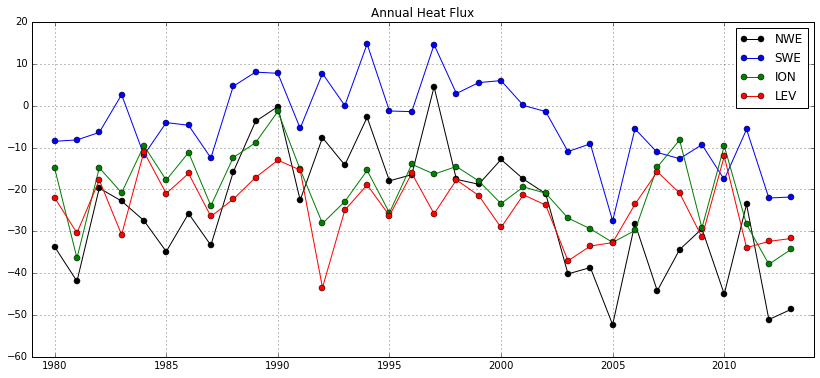

In [8]:
# NEW DJF test!!!
col_list = ['k','b','g','r']
count_col=0
plt.figure(figsize=(14,6))
# Keeping only winter values
for basin in region_list:
    #vars()['hf3_'+basin] = vars()['hf2_'+basin].loc[(vars()['hf2_'+basin]['mm']==1)|(vars()['hf2_'+basin]['mm']==2)|(vars()['hf2_'+basin]['mm']==12)]
    count = 0
    vars()['hf_mean_DJF_'+basin] = np.zeros([34])
    for y in year_list:
        vars()['hf_mean_DJF_'+basin][count] =  vars()['hf2_'+basin].groupby('yy_corr')['total_hf'].mean()[y]
        count += 1
        
    # figure    
    plt.plot(year_list, vars()['hf_mean_DJF_'+basin], '-o',color=col_list[count_col],label=basin)
    count_col += 1
plt.grid(True)
plt.title('Annual Heat Flux')
plt.xlim([1979,2014])
plt.legend()

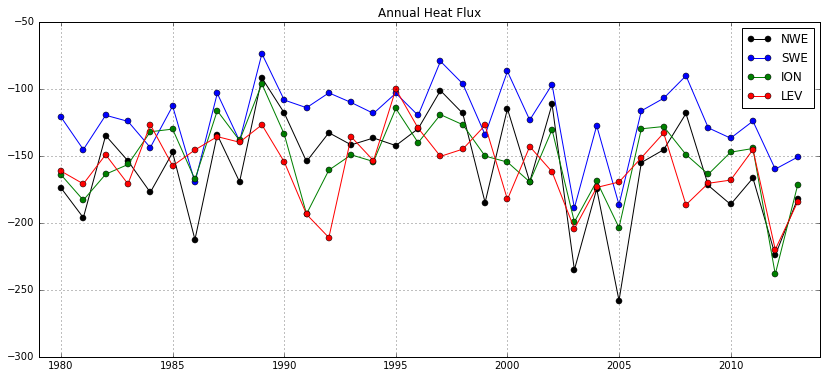

In [6]:
# BAD DJF
col_list = ['k','b','g','r']
count_col=0
plt.figure(figsize=(14,6))
# Keeping only winter values
for basin in region_list:
    vars()['hf3_'+basin] = vars()['hf2_'+basin].loc[(vars()['hf2_'+basin]['mm']==1)|(vars()['hf2_'+basin]['mm']==2)|(vars()['hf2_'+basin]['mm']==12)]
    count = 0
    vars()['hf_mean_DJF_'+basin] = np.zeros([34])
    for y in year_list:
        vars()['hf_mean_DJF_'+basin][count] =  vars()['hf3_'+basin].groupby('yy')['total_hf'].mean()[y]
        count += 1
        
    # figure    
    plt.plot(year_list, vars()['hf_mean_DJF_'+basin], '-o',color=col_list[count_col],label=basin)
    count_col += 1
plt.grid(True)
plt.title('Annual Heat Flux')
plt.xlim([1979,2014])
plt.legend()

In [9]:
np.shape(hf_mean_DJF_ION)

# Saving txt file
HF_stack = np.vstack([hf_mean_DJF_NWE,hf_mean_DJF_SWE,hf_mean_DJF_ION,hf_mean_DJF_LEV])
np.shape(HF_stack) # (4, 34)


HF_mean_DJF = HF_stack.transpose()
#MLD_mean_DJF
# FINALLY
np.savetxt('HF_DJF_4zones.txt',HF_mean_DJF,delimiter=' ')  # => YES!

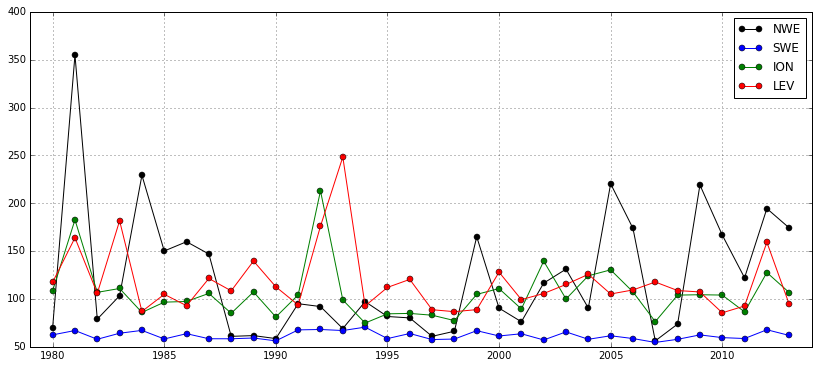

In [10]:
### CREATING A NEW MLD DJF txt FILE ###

file_path = '../DATA/LONG_SIMS/BestAjustRivE_BoostW/PHYSICS/'

MLD_DJF_df = pd.read_table(file_path+'result_mld_DJF',names=['year','month','day','NWE','SWE','ION','LEV'],delimiter='\s+')
#MLD_DJF_df.head()

#np.shape(MLD_DJF_df) #(613,7)
yy_corr = np.zeros([613])
yy_corr[:] = np.nan

for o in np.arange(0,len(MLD_DJF_df)):
    if MLD_DJF_df['month'][o] == 12:
        yy_corr[o] = MLD_DJF_df['year'][o]+1
    else:
        yy_corr[o] = MLD_DJF_df['year'][o]
#yy_corr

MLD_DJF_df['yy_corr'] = yy_corr
MLD_DJF_df.head()
#MLD_DJF_df.tail(n=20) # seems ok!

col_list = ['k','b','g','r']
count_col=0
plt.figure(figsize=(14,6))

# Keeping only winter values
for basin in region_list:
    count = 0
    vars()['MLD_mean_DJF_'+basin] = np.zeros([34])
    for y in year_list:
        vars()['MLD_mean_DJF_'+basin][count] =  MLD_DJF_df.groupby('yy_corr')[basin].mean()[y]
        count += 1
        
    # figure
    plt.plot(year_list, vars()['MLD_mean_DJF_'+basin], '-o',color=col_list[count_col],label=basin)
    #print count_col
    count_col += 1
plt.grid(True)    
plt.legend()
    #eval('plt.title(\'Annual Heat Flux '+basin+'\')')
plt.xlim([1979,2014])
    #eval('plt.savefig(\'/home/dosa/THESE/CR_reunions/MAY_FIGS/CR_21.05.2018/LAST_FIGS/Annual_HF_'+basin+'.png\',bbox_inches=\'tight\',format=\'png\')')
    
# Saving txt file
MLD_stack = np.vstack([MLD_mean_DJF_NWE,MLD_mean_DJF_SWE,MLD_mean_DJF_ION,MLD_mean_DJF_LEV])
np.shape(MLD_stack) # (4, 34)


MLD_mean_DJF = MLD_stack.transpose()
#MLD_mean_DJF
# FINALLY
#np.savetxt('MLD_DJF_4zones_Alex.txt',MLD_mean_DJF,delimiter=' ')  # => YES!

In [28]:
np.shape(MLD_mean_DJF)
np.shape(HF_mean_DJF)

(34, 4)

In [11]:
### Loop on ppb netppb and org ###
# mean, then min and max
var_list = ['ppb', 'netppb', 'export_nit_sw', 'export_pho_sw']
treat_list = ['mean', 'min', 'max'] # 'mean', 'min', 'max'
year_list = np.arange(1980,2014)

for var in var_list:
    for treatment in treat_list:
        #print treatment
        for basin in region_list:
            # NO DJF!!!
            #vars()[var+'_'+treatment+'_'+basin] = vars()[var+'_2D_'+basin]
            #vars()[var+'_'+treatment+'_'+basin]['mm'] = pd.DatetimeIndex(vars()[var+'_'+treatment+'_'+basin]['date']).month
            #vars()[var+'_new_'+treatment+'_'+basin] = vars()[var+'_'+treatment+'_'+basin].loc[(vars()[var+'_'+treatment+'_'+basin]['mm']==1)|(vars()[var+'_'+treatment+'_'+basin]['mm']==2)|(vars()[var+'_'+treatment+'_'+basin]['mm']==12)]
            vars()[var+'_2D_'+basin]['mm'] = pd.DatetimeIndex(vars()[var+'_2D_'+basin]['date']).month
            count = 0
            vars()[var+'_'+treatment+'_'+basin] = np.zeros([34])
            for y in year_list:
                if treatment == 'mean':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_2D_'+basin].groupby('yy')['var'].mean()[y]
                elif treatment == 'min':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_2D_'+basin].groupby('yy')['var'].min()[y]
                elif treatment == 'max':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_2D_'+basin].groupby('yy')['var'].max()[y]
                else:
                    print 'treatment not properly defined'
                count += 1
            #print var+'_'+treatment+'_'+basin
            
for var in var_list:
    for treatment in treat_list:
        # Saving txt file
        temp_stack = np.vstack([vars()[var+'_'+treatment+'_NWE'],vars()[var+'_'+treatment+'_SWE'],vars()[var+'_'+treatment+'_ION'],vars()[var+'_'+treatment+'_LEV']])
        print 'temp_stack', np.shape(temp_stack) # (4, 34)

        vars()[var+'_'+treatment+'_tocorr'] = temp_stack.transpose()
        temp_stack = None
        # FINALLY
        #eval('np.savetxt(\''+var+'_'+treatment+'_tocorr_4zones.txt\','+var+'_'+treatment+'_tocorr,delimiter=\' \')')  # => YES!

temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)
temp_stack (4, 34)


In [12]:
### Loop on Org C ###
# mean, then min and max
var_list = ['export_doc200', 'export_poc200']
treat_list = ['mean', 'min', 'max'] # 'mean', 'min', 'max'
year_list = np.arange(1980,2014)

for var in var_list:
    for treatment in treat_list:
        #print treatment
        for basin in region_list:
            vars()[var+'_2D_'+basin]['mm'] = pd.DatetimeIndex(vars()[var+'_2D_'+basin]['date']).month
            count = 0
            vars()[var+'_'+treatment+'_'+basin] = np.zeros([34])
            for y in year_list:
                if treatment == 'mean':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_2D_'+basin].groupby('yy')['var'].mean()[y]
                elif treatment == 'min':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_2D_'+basin].groupby('yy')['var'].min()[y]
                elif treatment == 'max':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_2D_'+basin].groupby('yy')['var'].max()[y]
                else:
                    print 'treatment not properly defined'
                count += 1
            
for var in var_list:
    for treatment in treat_list:
        # Saving txt file
        temp_stack = np.vstack([vars()[var+'_'+treatment+'_NWE'],vars()[var+'_'+treatment+'_SWE'],vars()[var+'_'+treatment+'_ION'],vars()[var+'_'+treatment+'_LEV']])
        #print 'temp_stack', np.shape(temp_stack) # (4, 34)

        vars()[var+'_'+treatment+'_tocorr'] = temp_stack.transpose()
        temp_stack = None
        # FINALLY
        #eval('np.savetxt(\''+var+'_'+treatment+'_tocorr_4zones.txt\','+var+'_'+treatment+'_tocorr,delimiter=\' \')')  # => YES!
    
print 'END of CELL'

END of CELL


In [13]:
# Export OC
for region in region_list:
    vars()['export_OC_'+region] = vars()['export_doc200_2D_'+region]
    vars()['export_OC_'+region]['var2'] = vars()['export_doc200_2D_'+region]['var'] + vars()['export_poc200_2D_'+region]['var']

### Loop on Org C ###
# mean, then min and max
var_list = ['export_OC']
treat_list = ['mean', 'min', 'max'] # 'mean', 'min', 'max'
year_list = np.arange(1980,2014)

for var in var_list:
    for treatment in treat_list:
        #print treatment
        for basin in region_list:
            vars()[var+'_'+basin]['mm'] = pd.DatetimeIndex(vars()[var+'_'+basin]['date']).month
            count = 0
            vars()[var+'_'+treatment+'_'+basin] = np.zeros([34])
            for y in year_list:
                if treatment == 'mean':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_'+basin].groupby('yy')['var2'].mean()[y]
                elif treatment == 'min':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_'+basin].groupby('yy')['var2'].min()[y]
                elif treatment == 'max':
                    vars()[var+'_'+treatment+'_'+basin][count] =  vars()[var+'_'+basin].groupby('yy')['var2'].max()[y]
                else:
                    print 'treatment not properly defined'
                count += 1
            
for var in var_list:
    for treatment in treat_list:
        # Saving txt file
        temp_stack = np.vstack([vars()[var+'_'+treatment+'_NWE'],vars()[var+'_'+treatment+'_SWE'],vars()[var+'_'+treatment+'_ION'],vars()[var+'_'+treatment+'_LEV']])
        #print 'temp_stack', np.shape(temp_stack) # (4, 34)

        vars()[var+'_'+treatment+'_tocorr'] = temp_stack.transpose()
        temp_stack = None
        # FINALLY
        #eval('np.savetxt(\''+var+'_'+treatment+'_tocorr_4zones.txt\','+var+'_'+treatment+'_tocorr,delimiter=\' \')')  # => YES!
    
print 'END of CELL'

END of CELL


In [14]:
### TEST correlation matrix ###

# mean NWE #
corr_df_mean_NWE = np.vstack([MLD_mean_DJF[:,0],HF_mean_DJF[:,0]])

In [15]:
corr_df_mean_NWE = pd.DataFrame(MLD_mean_DJF[:,0])
np.shape(corr_df_mean_NWE) # (34, 1)
corr_df_mean_NWE = corr_df_mean_NWE.rename(index=str,columns={0:"MLDwint"})

corr_df_mean_NWE['-HFwint'] = -HF_mean_DJF[:,0]
corr_df_mean_NWE['GPP'] = ppb_mean_tocorr[:,0]
corr_df_mean_NWE['GPPmax'] = ppb_max_tocorr[:,0]
#corr_df_mean_NWE['GPPmin'] = ppb_min_tocorr[:,0]
corr_df_mean_NWE['NetPP'] = netppb_mean_tocorr[:,0]
corr_df_mean_NWE['NetPPmax'] = netppb_max_tocorr[:,0]
#corr_df_mean_NWE['NetPPmin'] = netppb_min_tocorr[:,0]
corr_df_mean_NWE['NitImp'] = -export_nit_sw_mean_tocorr[:,0]
corr_df_mean_NWE['PhoImp'] = -export_pho_sw_mean_tocorr[:,0]
corr_df_mean_NWE['OCExp'] = export_OC_mean_tocorr[:,0]

corr_df_mean_NWE.head()

,MLDwint,-HFwint,GPP,GPPmax,NetPP,NetPPmax,NitImp,PhoImp,OCExp
0,70.120293,33.717231,1034.197203,1521.485596,483.912165,822.497803,0.536294,0.026845,1.992254
1,355.062586,41.943577,1011.941562,1554.419067,463.355166,857.398071,0.546491,0.035513,3.265132
2,78.935730,19.687112,1003.463854,1533.605713,462.861046,797.280579,0.173406,0.010022,2.007157
3,103.334143,22.787012,1038.814899,1590.776855,475.210162,914.705200,0.389502,0.020969,2.173447
4,229.338972,27.459077,1012.522464,1733.680176,475.707080,971.632080,0.676651,0.042481,3.554770


In [16]:
## Loop over Basins
for basin in region_list:
    if basin == 'NWE':
        this_ind = 0
    elif basin == 'SWE':
        this_ind = 1
    elif basin == 'ION':
        this_ind = 2
    elif basin == 'LEV':
        this_ind = 3
    else:
        print 'Unknown basin'
        
    vars()['corr_df_mean_'+basin] = pd.DataFrame(MLD_mean_DJF[:,this_ind])
    vars()['corr_df_mean_'+basin] = vars()['corr_df_mean_'+basin].rename(index=str,columns={0:"MLDwint"})

    vars()['corr_df_mean_'+basin]['-HFwint'] = -HF_mean_DJF[:,this_ind]
    vars()['corr_df_mean_'+basin]['GPP'] = ppb_mean_tocorr[:,this_ind]
    vars()['corr_df_mean_'+basin]['GPPmax'] = ppb_max_tocorr[:,this_ind]
    #vars()['corr_df_mean_'+basin]['GPPmin'] = ppb_min_tocorr[:,this_ind]
    vars()['corr_df_mean_'+basin]['NetPP'] = netppb_mean_tocorr[:,this_ind]
    vars()['corr_df_mean_'+basin]['NetPPmax'] = netppb_max_tocorr[:,this_ind]
    #vars()['corr_df_mean_'+basin]['NetPPmin'] = netppb_min_tocorr[:,this_ind]
    vars()['corr_df_mean_'+basin]['NitImp'] = -export_nit_sw_mean_tocorr[:,this_ind]
    vars()['corr_df_mean_'+basin]['PhoImp'] = -export_pho_sw_mean_tocorr[:,this_ind]
    vars()['corr_df_mean_'+basin]['OCExp'] = export_OC_mean_tocorr[:,this_ind]
        
    vars()['corr_df_mean_'+basin].head()

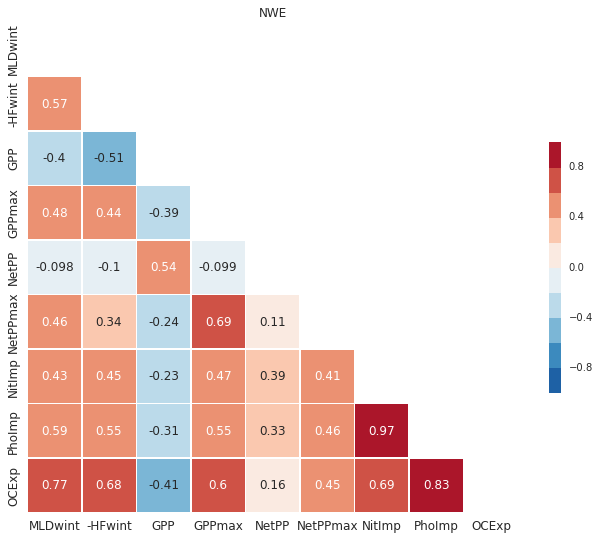

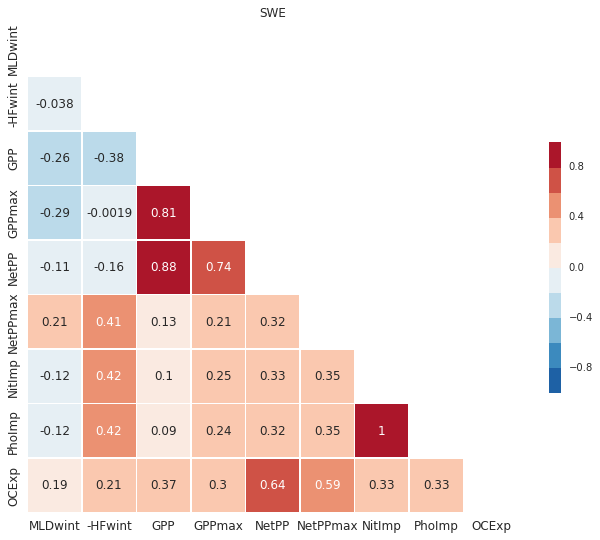

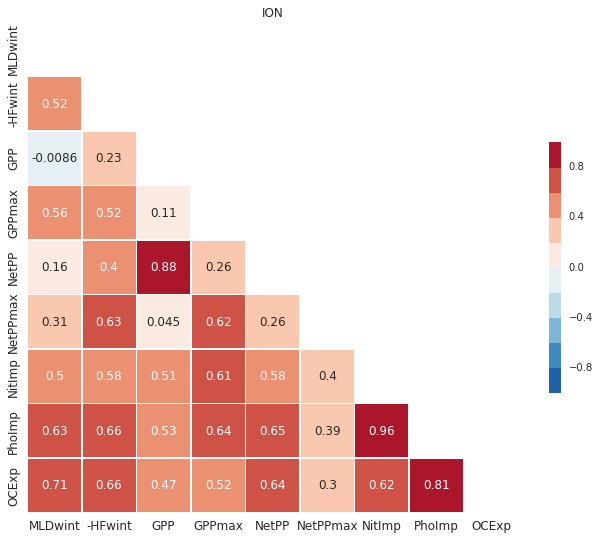

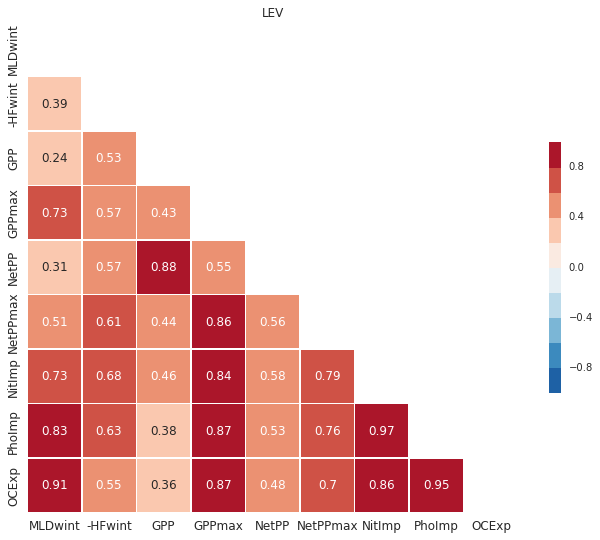

In [17]:
### LOOP over basins ###

for basin in region_list:
    vars()['corr_mean_'+basin] = vars()['corr_df_mean_'+basin].corr()

    from string import ascii_letters
    import seaborn as sns

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(vars()['corr_mean_'+basin], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.color_palette('RdBu_r',10) # BrBG_r

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(vars()['corr_mean_'+basin], mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) #vmax=1, vmin=-1,
    plt.title(basin, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.savefig('/home/dosa/THESE/CR_reunions/MAY_FIGS/CR_21.05.2018/LAST_FIGS/CORR_MATRICES/'+basin+'_Small_CorrMat.png',bbox_inches='tight',format='png')

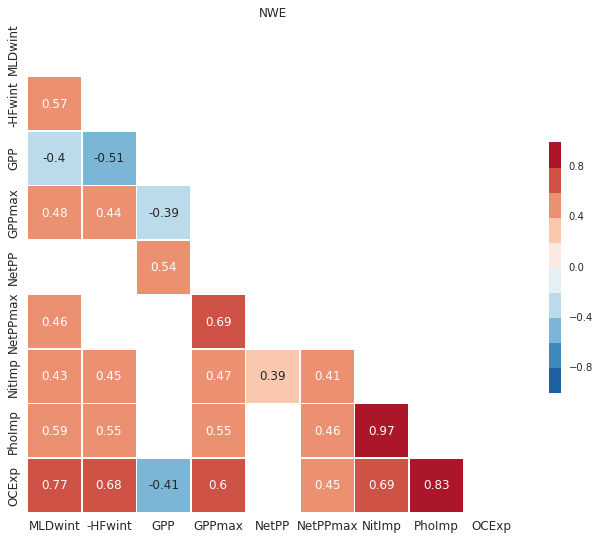

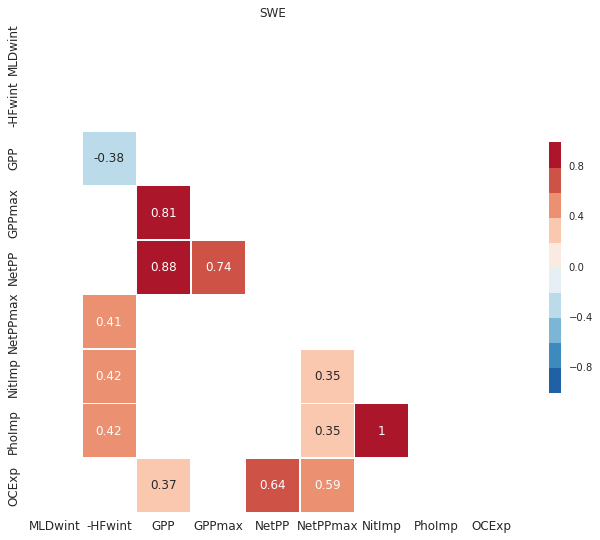

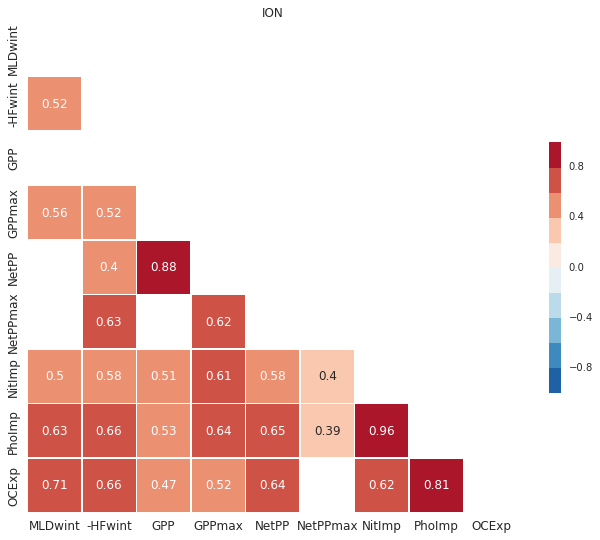

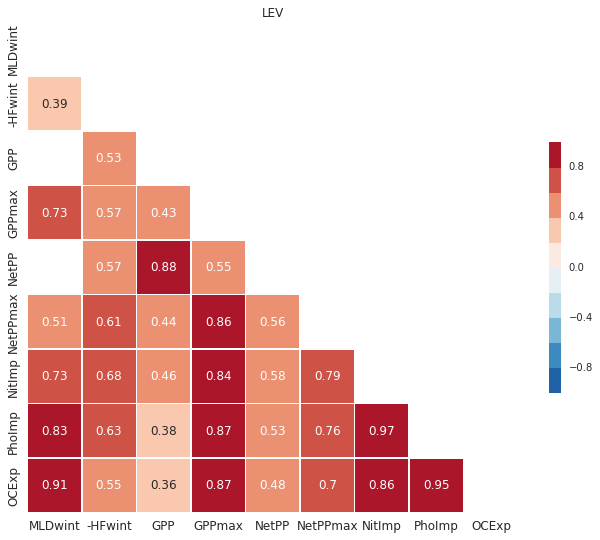

In [19]:
### NEW LOOP over basins, removing non significant correlation values ###

# test p-value
from scipy.stats import pearsonr

from string import ascii_letters
import seaborn as sns
column_names = ['MLDwint','-HFwint','GPP','GPPmax','NetPP','NetPPmax','NitImp','PhoImp','OCExp'] #'GPPmin','NetPPmin',

for basin in region_list:
    vars()['corr_mean_'+basin] = vars()['corr_df_mean_'+basin].corr()

    for i in np.arange(0,len(column_names)):
        var1 = column_names[i]

        for j in np.arange(0,len(column_names)):
            var2 = column_names[j]

            if pearsonr(vars()['corr_df_mean_'+basin][var1],vars()['corr_df_mean_'+basin][var2])[1]>0.05:
                vars()['corr_mean_'+basin][var1][j] = None
                vars()['corr_mean_'+basin][var2][i] = None
    
    #####

    sns.set(style="white")

    # Generate a mask for the upper triangle
    mask = np.zeros_like(vars()['corr_mean_'+basin], dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    #cmap = sns.diverging_palette(220, 10, as_cmap=True)
    cmap = sns.color_palette('RdBu_r',10) # BrBG_r

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(vars()['corr_mean_'+basin], mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,annot=True,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}) #vmax=1, vmin=-1,
    plt.title(basin, fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.savefig('/home/dosa/THESE/CR_reunions/MAY_FIGS/CR_21.05.2018/LAST_FIGS/CORR_MATRICES/'+basin+'_Small_Signif_CorrMat.png',bbox_inches='tight',format='png')